# SVB evaluation

This is a preliminary evaluation of hyrbid SVB and comparison with volumetric BASIL. 

A single cortical hemisphere at 32k mesh resolution (HCP functional standard) is used to define anatomy. A sinusoidal variation of CBF is simulated on the cortical surface, whereas all other parameters (WM CBF, GM ATT, WM ATT) are assigned constant default values across the brain. No subcortical GM structures are considered. 

Multi-time ASL data is simulated with increasing levels of noise, and then the following analysis pipelines run: 
1. Hybrid SVB, inferring both CBF and ATT, using spatial priors on both parameters. All GM parameters are estimated on the surface, and WM in the volume.  
2. BASIL volumetric PVEc (via oxford_asl), inferring both CBF and ATT, with a spatial prior on CBF only, followed by volume -> surface projection with Toblerone to transform GM parameters. 


High level summary of results: 
1. Hybrid SVB seems to work (at last)
2. For cortical CBF, there is a clear divergence with BASIL at very high noise levels: BASIL smooths over all detail to return a normal distribution, whereas SVB actually returns increasingly wide distributions to preserve spatial detail (the bright spots are even brighter, and vice-versa)
3. Qualitatively, I think an argument can be made that SVB has some advantages over BASIL at high noise. What metric could we use to show this quantitatively?
4. How much noise is too much? Are the values used below realistic or are they too pathlogically difficult to be realistic?
5. The spatial prior on ATT in SVB isn't as constraining as the normal prior in BASIL. When I use a normal prior in SVB, that seems to perform even worse than the spatial one. Thinking out loud, could we implement the combined spatial and non-spatial prior in SVB? If we are willing to approximate the two priors as statistically independent, then we could just calculate the log(cost) over each prior and sum them together for the objective function?
6. It is difficult to be sure convergence has been reached in SVB under a fixed number of epochs. 


In [1]:
%load_ext autoreload 
%autoreload 2 

import sys 
import numpy as np
import toblerone as tob 
import copy 

import matplotlib.pyplot as plt 
from matplotlib.cm import get_cmap
cmap = np.array(get_cmap('tab10').colors)
import seaborn as sns 
import pyvista as pv 
import pandas as pd 
import nibabel as nib 
from scipy import stats
import regtricks as rt 

sys.path.insert(1, '/Users/thomaskirk/Modules/svb_module')
from svb.main import run
from svb.data import HybridModel

import fabber_funcs
import os.path as op
sys.path.insert(1, '/Users/thomaskirk/Modules/svb_models_asl')
from svb_models_asl import AslRestModel 

niiload = lambda p: nib.load(p).get_fdata().flatten()
giiload = lambda p: nib.load(p).darrays[0].data 

ANATOMY = 'brain'

try:
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
except ImportError:
    import tensorflow as tf

Instructions for updating:
non-resource variables are not supported in the long term


Load up a pre-computed projector for the single hemisphere. The voxel grid is 3mm isotropic. 

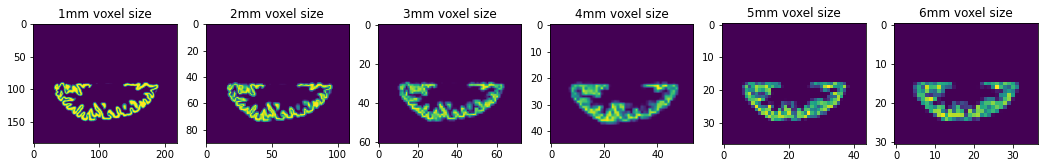

In [18]:
proj_base = tob.Projector.load(f'{ANATOMY}_proj.h5')
vox_sizes = np.array([1,2,3,4,5,6])

projectors = {}
fig, axes = plt.subplots(1, len(vox_sizes), figsize=(3*len(vox_sizes),3))
for v,ax in zip(vox_sizes, axes): 
    spc = proj_base.spc.resize_voxels(v / proj_base.spc.vox_size, mode='ceil')
    proj_path = f'{ANATOMY}_proj_{v}.h5'
    if not op.exists(proj_path): 
        p = tob.Projector(proj_base.hemi_dict['L'], spc)
        p.save(proj_path)
    p = tob.Projector.load(proj_path)
    projectors[v] = p 
    ax.imshow(p.pvs()[:,:,p.spc.size[-1]//2,0])
    ax.set_title(f'{v}mm voxel size')

vox_sizes = vox_sizes[2:]

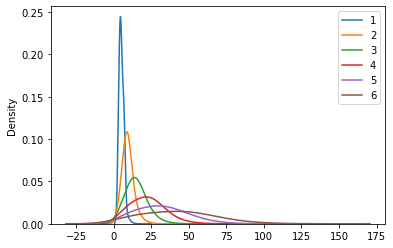

In [3]:
fig, ax = plt.subplots() 
for v, p in projectors.items(): 
    v2s = (p.vol2surf_matrix(False) > 0)
    vertex_count = v2s.sum(0).A.flatten()
    sns.kdeplot(vertex_count[vertex_count > 0], label=v, ax=ax, bw=0.5)

ax.legend()

In [4]:
hemi = proj_base.hemi_dict['L']
midsurf = hemi.midsurface()
if ANATOMY == 'sph': 
    LIS = hemi.midsurface()
else: 
    LIS = tob.Surface('103818.L.very_inflated.32k_fs_LR.surf.gii')
thick_mask = np.linalg.norm(hemi.outSurf.points - hemi.inSurf.points, ord=2, axis=-1)
thick_mask = (thick_mask > 0.5)

Simulate sinusoidal CBF map on the cortical *inflated* surface (this gives a smoother and less convoluted map). 

In [5]:
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy)
    az = np.arctan2(y, x)
    return az, el, r

az, el, r = cart2sph(*(LIS.points - LIS.points.mean(0)).T)

def pv_plot(surface, data, **kwargs):
    pl = pv.Plotter(window_size=(600, 400))
    faces = 3 * np.ones((surface.tris.shape[0], 4), dtype=int)
    faces[:,1:] = surface.tris 
    mesh = pv.PolyData(surface.points, faces=faces)
    pl.add_mesh(mesh, scalars=data, **kwargs)
    pl.show(jupyter_backend='pythreejs')

scale = 7
ctx_cbf = 40 + 20 * (np.sin(scale * el)**2 + np.sin(scale/2 * az)**2)
pv_plot(LIS, ctx_cbf, clim=[40, 80]) 

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, 1…

ASL parameters: multi-PLD pCASL 

In [6]:
PLDS = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5]
BOLUS = 1.8
ATT = [1.3, 1.6]
BASIL_OPTS = { 'bolus': BOLUS, 'bat': ATT[0], 'batwm': ATT[1], 'plds': PLDS, 'ibf': 'tis' }
nverts = midsurf.n_points

Function to simulate data using SVB's *aslrest* model. NB: data is simulated from hybrid space parameters (ie, a set of surface ground truth values, volumetric ground truth), and then projected down into a volumetric representation. This is fundamentally different to simulating data starting from volumetic parameter values. 

In [7]:
def simulate_data(noise, rpt, proj, mask):

    spc = proj.spc 
    nvox = spc.size.prod()
    data = np.zeros((*spc.size, len(PLDS) * rpt))
    data_model = HybridModel(spc.make_nifti(data), projector=proj)
    asl_model = AslRestModel(data_model,
            plds=PLDS, repeats=rpt, casl=True, inferatt=False)

    with tf.Session() as sess:
        cbf = np.concatenate([
                ctx_cbf[:,None], 20 * np.ones([nvox, 1]) ])

        data = sess.run(asl_model.evaluate(
                [ cbf.astype(np.float32) ], asl_model.tpts()))

    data = proj.hybrid2vol(data, edge_scale=True).reshape(*spc.size, -1)
    data[mask,:] += np.random.normal(0, noise, size=data[mask,:].shape)
    return data


SVB inference / optimisation options used for all runs. 2000 epochs is probably a bit on the long side, 1000 normally is enough. 

In [8]:
RPT = 8
proj_base = projectors[1]
mask_base = (proj_base.pvs()[...,:2] > 0.1).any(-1)
data_base = simulate_data(0, RPT, proj_base, mask_base)
data_base.shape

2022-05-19 22:49:58.105399: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(183, 219, 183, 48)

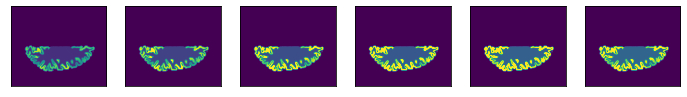

In [9]:
fig, axes = plt.subplots(1,6, figsize=(12,2))
for pld, ax in enumerate(axes): 
    start = (pld * RPT) 
    end = start + RPT 
    ax.imshow(data_base[:,:,proj_base.spc.size[-1]//2,start:end].mean(-1), vmin=0, vmax=40)
    ax.set_xticks([])
    ax.set_yticks([])

In [10]:
sig_all_pld = data_base[mask_base,:].mean(-1)
gm = sig_all_pld > np.percentile(sig_all_pld, 80)
pld_signals = []
for pld in range(6): 
    start = (pld * RPT)  
    end = start + RPT 
    data_pld = data_base[mask_base,start:end]
    sig = data_pld.mean(-1)
    pld_signals.append( sig[gm].mean() )

mu = max(pld_signals)
mu 

58.14730737723989

In [11]:
SNR_RATIO = [-1,-0.5,0,0.5,1]
get_snr = lambda vox_vol: 3.3 * ((vox_vol / 58.49) ** 0.5)

input_data = {} 
for snr_ratio in SNR_RATIO:
    input_data[snr_ratio] = {} 
    snr_eff = get_snr(1 ** 3) * (2 ** snr_ratio) 
    noise_base = mu / snr_eff 
    np.random.seed(1)
    d = data_base + np.random.normal(0, noise_base, size=data_base.shape)

    for v in vox_sizes: 
        spc_v = projectors[v].spc 
        data_v = rt.Registration.identity().apply_to_array(d, src=proj_base.spc, ref=spc_v, order=1)
        input_data[snr_ratio][v] = data_v

(2.0416129355283745, 2.8202050098720055, 3.4333227177470973)

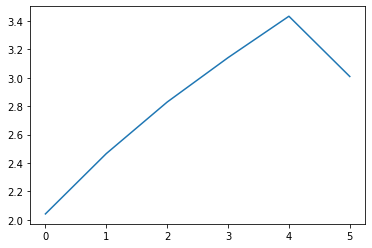

In [12]:
v = 4
snr = 0 
mask = (projectors[v].pvs()[...,:2] > 0.1).any(-1)
sig_all_pld = input_data[0][v][mask,:].mean(-1)
gm = sig_all_pld > np.percentile(sig_all_pld, 80)

y = []
for pld in range(6): 
    start = (pld * RPT) 
    end = start + RPT 
    data_pld = input_data[0][v][mask,start:end]
    sig = data_pld.mean(-1)
    noise = data_pld.std(-1)
    y.append( (sig[gm] / noise[gm]).mean() )

plt.plot(y)
np.min(y), np.mean(y), np.max(y)

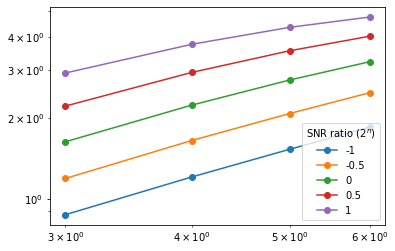

In [19]:
snrs = [] 
for snr_ratio in SNR_RATIO: 
    s = [] 
    for v in vox_sizes: 
        mask = (projectors[v].pvs()[...,:2] > 0.05).any(-1)
        d = input_data[snr_ratio][v][mask,:]
        sig = d.mean(-1)
        gm = (sig > np.percentile(sig, 80))
        noise = d[gm].std(-1)
        x = sig[gm] / noise 
        s.append( x.mean() )
    snrs.append(s)

snrs = np.array(snrs)
fig, ax = plt.subplots()
ax.plot(vox_sizes, snrs.T, marker='o')
ax.legend(SNR_RATIO, title=r'SNR ratio (2$^n$)')
ax.set_xscale('log')
ax.set_yscale('log')

In [20]:
options = {
    "mode": "hybrid", 

    "learning_rate" : 0.2,
    "lr_decay_rate": 0.5, 
    "sample_size" : 2,
    "ss_increase_factor": 5, 
    "epochs" : 2500,

    "batch_size" : len(PLDS),
    "log_stream" : sys.stdout,
    "plds": PLDS, 
    "casl": True, 
    "prior_type": "M",
    "display_step": 50, 

    "save_model_fit": True, 
    "save_mean": True, 
    "save_input": True, 

}

The experiment: simulate data with increasing noise, and run both SVB and BASIL on them. There are 4 ASL repeats per PLD, which makes (4 * 6) volumes in total. 

In [21]:
oxasl_jobs = [] 

for v in vox_sizes: 
    proj = projectors[v]
    mask = (proj.pvs()[...,:2] > 0.05).any(-1)
    pvs = proj.pvs()

    # Run with a fixed low level of noise and varying numbers of repeats 
    for snr in SNR_RATIO:
        # BASIL infer att 
        data = input_data[snr][v]
        odir = f"{ANATOMY}_test/basil_vox-{v}_snr-{snr}_rpt-{RPT}"
        if not op.exists(op.join(odir, 'output')):
            oxasl_jobs.append( (data, mask.astype(np.int8), odir, BASIL_OPTS, pvs[...,:2], proj) )

from multiprocessing import Pool
with Pool() as pool: 
    pool.starmap(fabber_funcs.oxasl_cmd, oxasl_jobs)

for v in vox_sizes: 
    proj = projectors[v]
    mask = (proj.pvs()[...,:2] > 0.05).any(-1)
    pvs = proj.pvs()

    # Run with a fixed low level of noise and varying numbers of repeats 
    for snr in SNR_RATIO:                    
        # SVB infer att 
        data = input_data[snr][v]
        odir = f"{ANATOMY}_test/svb_vox-{v}_snr-{snr}_rpt-{RPT}"
        if not op.exists(op.join(odir, 'mean_ftiss.nii.gz')):
            run(proj.spc.make_nifti(data), "aslrest",
                odir, repeats=RPT, projector=proj, mask=mask,
                **options)



INFO : SVB 0.0.2.post163
INFO : Model: ASL resting state model: 0.0.1.post40
INFO :  - Bolus duration: 1.8
INFO :  - Data is CASL/pCASL: True
INFO :  - Inversion times: [2.05, 2.3, 2.55, 2.8, 3.05, 3.3]
INFO :  - Post-labelling delays (for CASL instead of TIs): [0.25, 0.5, 0.75, 1.0, 1.25, 1.5]
INFO :  - Number of repeats - single value or one per TI/PLD: 8
INFO :  - Increase in TI/PLD per slice: 0
INFO :  - Tissue T1 value: array of shape (52592,), mean 1.2
INFO :  - Bolus arrival time: array of shape (52592,), mean 1.4
INFO :  - Bolus arrival time prior std.dev.: 1.0
INFO :  - Perfusion value to use in estimation of effective T1: array of shape (52592,), mean 0.0073
INFO :  - Blood/tissue partition coefficient. If only inferring on one tissue, default is 0.9; if inferring on both GM/WM default is 0.98/0.8 respectively. See --pcwm: array of shape (52592,), mean 0.91
INFO :  - Include WM parameters: False
INFO :  - WM perfusion: 0
INFO :  - WM arterial transit time: 1.6
INFO :  - WM T1

In [22]:
df = []
for v in vox_sizes: 

    proj = projectors[v]
    mask = (proj.pvs()[...,:2] > 0.05).any(-1)
    pvs = proj.pvs()

    # Run with a fixed low level of noise and varying numbers of repeats 
    for snr in SNR_RATIO:

        odir = f"{ANATOMY}_test/basil_vox-{v}_snr-{snr}_rpt-{RPT}"
        gm_cbf_v = niiload(op.join(odir, 'output_pvcorr/native/perfusion.nii.gz'))
        gm_cbf = proj.vol2surf(gm_cbf_v.flatten(), edge_scale=False)    
        wm_cbf = niiload(op.join(odir, 'output_pvcorr/native/perfusion_wm.nii.gz'))
        gm_att_v = niiload(op.join(odir, 'output_pvcorr/native/arrival.nii.gz'))
        gm_att = proj.vol2surf(gm_att_v.flatten(), edge_scale=False)    
        wm_att = niiload(op.join(odir, 'output_pvcorr/native/arrival_wm.nii.gz'))
        df.append({ 'method': 'basil', 'vox': v, 'snr': snr, 'vox': v, 'gm_cbf': gm_cbf, 
                    'wm_cbf': wm_cbf, 'gm_att': gm_att, 'wm_att': wm_att })
                    
        odir = f"{ANATOMY}_test/svb_vox-{v}_snr-{snr}_rpt-{RPT}"
        gm_cbf = giiload(op.join(odir, 'mean_ftiss_L_cortex.func.gii'))
        wm_cbf = niiload(op.join(odir, 'mean_ftiss.nii.gz'))
        gm_att = giiload(op.join(odir, 'mean_delttiss_L_cortex.func.gii'))
        wm_att = niiload(op.join(odir, 'mean_delttiss.nii.gz'))
        df.append({ 'method': 'svb', 'vox': v, 'snr': snr, 'gm_cbf': gm_cbf, 
                    'wm_cbf': wm_cbf, 'gm_att': gm_att, 'wm_att': wm_att })

df = pd.DataFrame(df).set_index(['method', 'vox', 'snr'])

## Analysis 1

Surface plots of esimated GM CBF. Note the plot is fully interactive (you can pan and rotate the surfaces), and the colour scale is fixed to the same range for all plots. 

At low levels of noise, BASIL does a remarkably good job of reproducing ground truth, though the intensity of bright / dark spots is definitely clipped a bit. SVB better preserves the full intensity of these details. 

With increasing noise, BASIL tends towards a smooth CBF map and loses further intensity compared to ground truth. By contrast, the SVB map becomes more extreme (the bright spots get brighter, and the dark darker), though in a qualitative sense I believe the spatial detail of ground truth is better preserved. 

In [23]:
df.head()

,,,gm_cbf,wm_cbf,gm_att,wm_att
method,vox,snr,,,,
basil,3,-1.0,"[54.67063457835771, 60.21437560454109, 68.1054...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.4352689218925954, 1.413488052381559, 1.2896...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
svb,3,-1.0,"[48.97776, 70.31075, 72.3899, 77.94997, 52.938...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.3638994, 1.3892773, 1.3479829, 1.5686196, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
basil,3,-0.5,"[53.36639550119685, 61.03010365242257, 66.8017...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.4122349371462521, 1.34090568580063, 1.29433...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
svb,3,-0.5,"[46.76879, 69.502686, 68.85079, 75.117195, 53....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.3257821, 1.4198353, 1.337947, 1.4575285, 1....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
basil,3,0.0,"[52.718114776570644, 62.35075215012724, 66.238...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.3635699306514764, 1.3000672944729248, 1.324...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [24]:
pl = pv.Plotter(shape=(len(SNR_RATIO), 3), window_size=(1200,2500))
faces = 3 * np.ones((LIS.tris.shape[0], 4), dtype=int)
faces[:,1:] = LIS.tris 
mesh = pv.PolyData(LIS.points, faces=faces)

for idx,snr in enumerate(SNR_RATIO): 

    basil, svb = df.xs((3, snr), level=['vox','snr']).gm_cbf
    pl.subplot(idx,0)
    m = copy.deepcopy(mesh).rotate_z(240, inplace=False)
    actor = pl.add_mesh(m, scalars=basil, clim=[40,80])
    pl.add_title('BASIL SNR ratio 2^%.1f' % snr)

    pl.subplot(idx,1)
    m = copy.deepcopy(mesh).rotate_z(240, inplace=False)
    actor = pl.add_mesh(m, scalars=ctx_cbf, clim=[40,80])
    pl.add_title(f'Truth')

    pl.subplot(idx,2)
    m = copy.deepcopy(mesh).rotate_z(240, inplace=False)
    actor = pl.add_mesh(m, scalars=svb, clim=[40,80])
    pl.add_title('SVB SNR ratio 2^%.1f' % snr)

pl.show(jupyter_backend='panel')

BokehModel(combine_events=True, render_bundle={'docs_json': {'e7040a4c-cbde-4093-8e12-b9da9e227a69': {'defs': …

## Analysis 2

Plot 1D distributions of cortical CBF. This helps illustrates the presence of bias and/or excessive smoothing as noise increases. 

Neither method shows any bias at all noise levels, but SVB returns a wider and wider distribution (the extremes are further apart), whereas BASIL returns an increasingly normal distribution at high noise levels. 

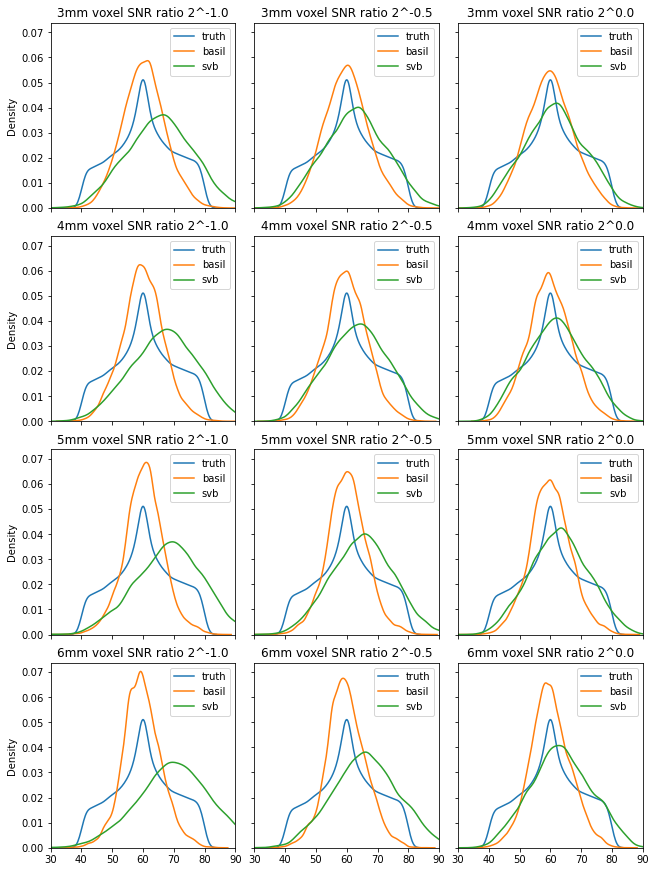

In [25]:
fig, axes_all = plt.subplots(len(vox_sizes), 3, constrained_layout=True, figsize=(9,len(vox_sizes)*3), sharex=True, sharey=True)

for idx, vox in enumerate(vox_sizes): 
    axes = axes_all[idx,:]
    for ax, snr in zip(axes.flat, SNR_RATIO): 
        sns.kdeplot(x=ctx_cbf[thick_mask], label='truth', ax=ax, color=cmap[0])
        sns.kdeplot(x=df.loc['basil', vox, snr]['gm_cbf'][thick_mask], label='basil', ax=ax, color=cmap[1])
        sns.kdeplot(x=df.loc['svb', vox, snr]['gm_cbf'][thick_mask], label='svb', ax=ax, color=cmap[2])

        ax.set_title(f'{vox}mm voxel SNR ratio 2^{snr:.1f}')
        ax.legend()
        ax.set_xlim(30, 90)


/var/folders/lv/mwp4mfb163n5t2wqyhm281vm0000gn/T/ipykernel_34260/3023628204.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


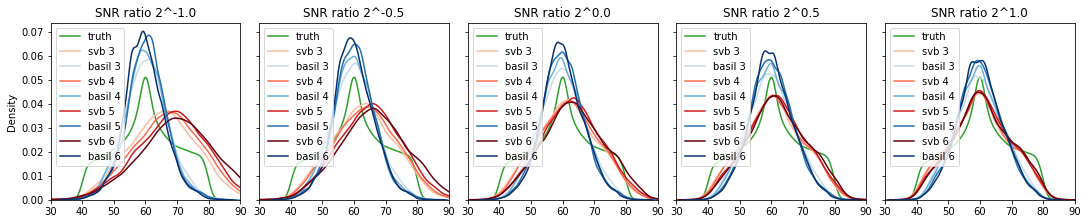

In [26]:
fig, axes_all = plt.subplots(1, 5, constrained_layout=True, figsize=(15,3), sharex=True, sharey=True)
reds = get_cmap('Reds')
blues = get_cmap('Blues')


for ax, snr in zip(axes_all, SNR_RATIO): 
    sns.kdeplot(x=ctx_cbf[thick_mask], label='truth', ax=ax, color=cmap[2])

    for vidx, v in enumerate(vox_sizes): 
        sns.kdeplot(x=df.loc['svb', v, snr]['gm_cbf'][thick_mask], label=f'svb {v}', ax=ax, color=reds((vidx+1)/vox_sizes.size))
        sns.kdeplot(x=df.loc['basil', v, snr]['gm_cbf'][thick_mask], label=f'basil {v}', ax=ax, color=blues((vidx+1)/vox_sizes.size))

    ax.set_title(f'SNR ratio 2^{snr:.1f}')
    ax.legend()
    ax.set_xlim(30, 90)

fig.show()

## Analysis 3

We can evaluate the accuracy of each methods estimates using sum of squared differences wrt. ground truth. Interestingly, this analysis shows SVB performs worse than BASIL for high noise levels (presumably because it returns more extreme CBF values than BASIL, which more and more resembles a normal distribution at high noise). 

Given the surface plots above suggest SVB does better preserve spatial detail at high noise, we can run an alternative analysis using Z-scores. The idea behind this is that spatial detail arises due to contrast between bright and dark spots; if SVB is able to maintain contrast in a relative sense at high noise, then the corresponding Z-scores should show this. Conversely, as BASIL's results tend towards a normal distribution, the associated Z-scores should suffer. 

On both of these metrics, SVB performs worse than BASIL on anything but the lowest noise values. And yet, from the surface plots, we can see that it is still conveying spatial detail at these noise levels. So, we need to think of a metric that conveys this - do you have any ideas?

In [27]:
cbf_ssd = df.gm_cbf.apply(lambda c: ((c - ctx_cbf)[thick_mask] ** 2).sum())

cortex_zscore = df.gm_cbf.apply(stats.zscore)
true_zscore = stats.zscore(ctx_cbf)
zscore_ssd = cortex_zscore.apply(lambda z: ((z - true_zscore)[thick_mask] ** 2).sum())

scores = pd.concat({'cbf_ssd': cbf_ssd, 'z_ssd': zscore_ssd}, axis=1)
scores.head()

,,,cbf_ssd,z_ssd
method,vox,snr,,
basil,3,-1.0,1.285108e+06,13247.408223
svb,3,-1.0,2.381575e+06,13843.417969
basil,3,-0.5,1.043121e+06,10407.492439
svb,3,-0.5,1.166100e+06,9536.599609
basil,3,0.0,8.250260e+05,7922.072847


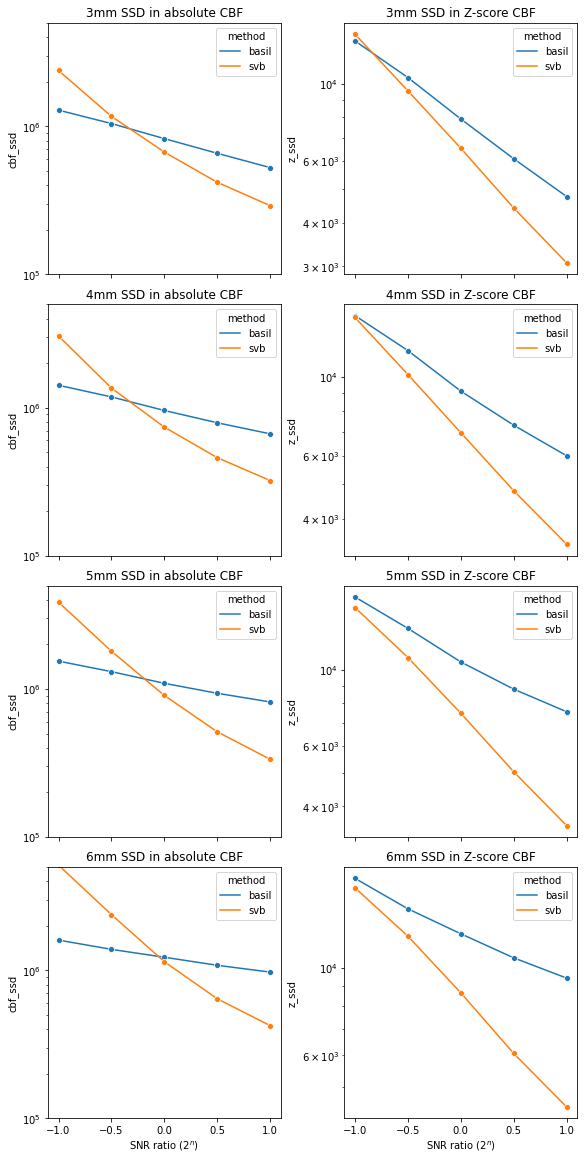

In [28]:
fig, axes_all = plt.subplots(len(vox_sizes), 2, sharex=True, constrained_layout=True, figsize=(8,len(vox_sizes) * 4))

for idx, v in enumerate(vox_sizes): 

    ax = axes_all[idx,0]
    sns.lineplot(data=scores.xs(v, level='vox'), x='snr', y='cbf_ssd', hue="method", marker='o', ax=ax)
    ax.set_title(f'{v}mm SSD in absolute CBF')
    ax.set_yscale('log')
    ax.set_xlabel(r'SNR ratio (2$^n$)')
    ax.set_ylim(1e5, 5e6)

    ax = axes_all[idx,1]
    sns.lineplot(data=scores.xs(v, level='vox'), x='snr', y='z_ssd', hue="method", marker='o', ax=ax)
    ax.set_title(f'{v}mm SSD in Z-score CBF')
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_xlabel(r'SNR ratio (2$^n$)')


In [ ]:
adj = LIS.adjacency_matrix()

def grow_regions(binary_mask):
    regions = [ ]
    thick_mask_inds = np.flatnonzero(thick_mask)
    for idx in np.flatnonzero(binary_mask):
        if any([ idx in r for r in regions ]): 
            continue 
        region = set([idx])
        old = copy.deepcopy(region)
        done = False 
        while not done: 
            for o in copy.deepcopy(old): 
                new = set([i for i in adj[o,:].indices if binary_mask[i]])
                old = old | new 
            done = (region == old) 
            region = copy.deepcopy(old)
        regions.append(list(region))
    return [ r for r in regions if np.in1d(r, thick_mask_inds).all() ] 

hyper = grow_regions((ctx_cbf > 75) & thick_mask)
hypo = grow_regions((ctx_cbf < 45) & thick_mask)
len(hyper)

54

In [ ]:
df.head(1)

,,,gm_cbf,wm_cbf,gm_att,wm_att
method,vox,snr,,,,
basil,3,-1,"[48.74993293535711, 69.28804911740812, 59.6218...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.02745937448433, 1.2176572534195866, 0.84470...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
rois = [] 
for snr in SNR_RATIO:
    for method in ['svb','basil']: 
        for v in vox_sizes: 
            cbf = df.loc[method,v,snr]['gm_cbf']
            cbf_z = stats.zscore(cbf)
            for idx,r in enumerate(hyper): 
                rois.append({ 'method': method, 'vox': v, 'snr': snr, 'type': 'hyper', 'roi': idx, 'mean_cbf': cbf[r].mean(), 'mean_z': cbf_z[r].mean() })
            for idx,r in enumerate(hypo): 
                rois.append({ 'method': method, 'vox': v, 'snr': snr, 'type': 'hypo', 'roi': idx, 'mean_cbf': cbf[r].mean(), 'mean_z': cbf_z[r].mean() })

rois = pd.DataFrame(rois)
rois.head()

,method,vox,snr,type,roi,mean_cbf,mean_z
0,svb,3,0,hyper,0,75.847733,1.620054
1,svb,3,0,hyper,1,61.464764,0.105034
2,svb,3,0,hyper,2,53.071682,-0.779043
3,svb,3,0,hyper,3,76.322807,1.670095
4,svb,3,0,hyper,4,76.286995,1.666322


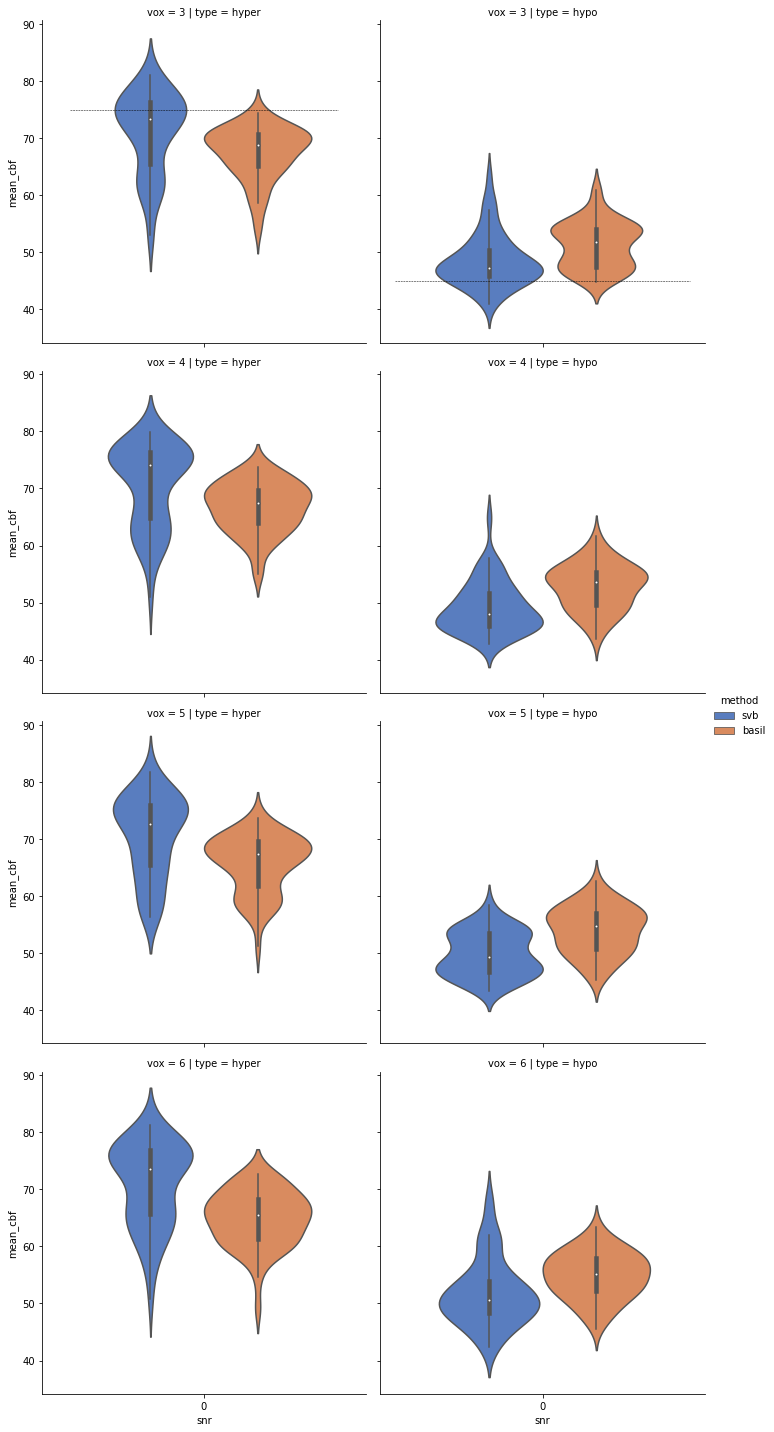

In [ ]:
g = sns.catplot(data=rois, x="snr", y="mean_cbf", hue="method", col="type", row='vox', kind="violin", palette="muted")
ax1 = g.axes[0,0]
ax1.plot(ax1.get_xlim(),[75,75], 'k--', linewidth=0.5)

ax2 = g.axes[0,1]
ax2.plot(ax2.get_xlim(),[45,45], 'k--', linewidth=0.5)


In [ ]:
g = sns.catplot(data=rois, x="snr", y="mean_z", hue="method", col="type", row='vox', kind="violin", palette="muted")
ax1 = g.axes[0,0]
# ax1.plot(ax1.get_xlim(),[75,75], 'k--', linewidth=0.5)

ax2 = g.axes[0,1]
# ax2.plot(ax2.get_xlim(),[45,45], 'k--', linewidth=0.5)

In [ ]:
df.head()

In [ ]:
fig, axes_all = plt.subplots(len(vox_sizes), 3, constrained_layout=True, figsize=(9,3*len(vox_sizes)))

for vidx,v in enumerate(vox_sizes): 
    keys = ['wm_cbf', 'gm_att', 'wm_att']
    truths = [ 20, 1.3, 1.6 ]
    lims = [[10,30], [1,1.6], [1,2.2]]
    p = projectors[v]
    mask = (p.pvs()[...,:2] > 0.05).any(-1)

    for ax, key, truth, lim in zip(axes_all[vidx,:], keys, truths, lims): 
        snr = 0 
        ax.set_title(r'%dmm voxel %s SNR ratio 2$^{%d}$' % (v, key, snr))
        m = mask.flatten() if ('wm' in key) else thick_mask
        sns.kdeplot(df.loc['basil',v,snr][key][m], ax=ax, label='BASIL', color=cmap[0])
        sns.kdeplot(df.loc['svb',v,snr][key][m], ax=ax, label='SVB', color=cmap[1])
        ax.plot([truth, truth], [0, ax.get_ylim()[1]], label='Truth', color=cmap[2], linestyle='--')
        ax.set_xlim(*lim)

    ax.legend()